In [58]:
import csv
import cv2
import importlib as imp
import itertools
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas
import scipy
import sklearn
import shutil
import tensorflow as tf
import time

from distutils.dir_util import copy_tree
from pandas.tools.plotting import scatter_matrix
#from scipy.spatial.distance import mahalanobis # Not vectorized and terribly slow!
from sklearn import mixture
from sklearn.decomposition import PCA, KernelPCA
from sklearn.metrics import silhouette_samples

pj = os.path.join

%matplotlib inline

In [4]:
import donkeycar as dk

Using TensorFlow backend.


In [54]:
g_tubs_dir = "J:/RaspberryPi/DonkeyCar/tubs"
g_tub_dir = pj(g_tubs_dir, "tubs_all")
g_tub_meta_dir = pj(g_tubs_dir, "tubs_raw")
g_videos_dir = "J:\RaspberryPi\DonkeyCar\videos"

X_keys = ['cam/image_array']
y_keys = ['user/angle', 'user/throttle']
X_key = X_keys[0]
ANGLE = y_keys[0]
THROT = y_keys[1]

In [59]:
if os.path.exists(g_tub_dir):
    shutil.rmtree(g_tub_dir)
    time.sleep(1)
os.makedirs(g_tub_dir)

dfull = pj( g_tub_meta_dir, os.listdir(g_tub_meta_dir)[0] )
copy_tree(dfull, g_tub_dir)

tub = dk.Tub(g_tub_dir)
for d in os.listdir(g_tub_meta_dir)[1:]:
    dfull = pj( g_tub_meta_dir, d )
    tub_d = dk.Tub(dfull)
    for i in range(tub_d.get_last_ix()):
        tub.put_record( tub_d.get_record(i) )

Tub does exist
Tub does exist
Tub does exist
Tub does exist


In [60]:
tub.get_record(22)

{'cam/image_array': array([[[ 36,  36,   0],
         [ 55,  55,   1],
         [ 73,  73,  19],
         ..., 
         [186, 219, 140],
         [181, 215, 131],
         [161, 197, 110]],
 
        [[ 53,  53,   0],
         [ 67,  67,  13],
         [ 80,  80,  26],
         ..., 
         [182, 212, 138],
         [189, 220, 142],
         [171, 202, 122]],
 
        [[ 67,  67,  13],
         [ 76,  76,  22],
         [ 83,  83,  29],
         ..., 
         [203, 225, 160],
         [185, 210, 142],
         [179, 205, 134]],
 
        ..., 
        [[ 25,  18,   0],
         [101,  91,  32],
         [198, 181, 111],
         ..., 
         [239, 221,  59],
         [255, 250,  72],
         [182, 167,   0]],
 
        [[ 78,  64,   3],
         [201, 186, 119],
         [217, 195, 119],
         ..., 
         [239, 217,  45],
         [232, 209,   9],
         [252, 229,  13]],
 
        [[202, 185, 116],
         [202, 182, 109],
         [204, 179,  97],
         ..., 
    

In [61]:
tub.get_last_ix()

14703

In [62]:
rec = tub.get_record(22)
f = cv2.cvtColor(rec[X_key], cv2.COLOR_RGB2BGR)
print(pj(g_donkey_dir, "tub_video.avi"))

J:/RaspberryPi/DonkeyCar/projects/donkey/donkeycar/tub_video.avi


In [63]:
def write_frames(frames, file_name, fps=30):
    if len(frames)==0:
        raise RuntimeError("Empty frames list")
    frame_size = (frames[0].shape[1], frames[0].shape[0])
    video_writer = cv2.VideoWriter(file_name, -1, fps, frame_size)
    for f in frames:
        video_writer.write(f)
    cv2.destroyAllWindows()
    video_writer.release()

In [64]:
frames_raw = []
for ix in range(tub.get_last_ix()):
    rec = tub.get_record(ix)
    f = cv2.cvtColor(rec[X_key], cv2.COLOR_RGB2BGR)
    frames_raw.append(f)

In [65]:
frames_h60 = []
for ix in range(tub.get_last_ix()):
    rec = tub.get_record(ix)
    f = cv2.cvtColor(rec[X_key], cv2.COLOR_RGB2BGR)
    frames_h60.append(f[60:,:,:])

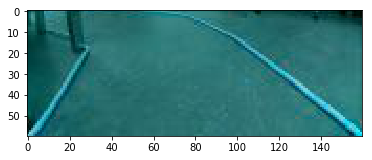

In [66]:
plt.imshow(frames_h60[0])

In [67]:
frames_2h = []
for f in frames_h60:
    f = cv2.resize(f, (160,120), interpolation = cv2.INTER_NEAREST)
    frames_2h.append(f)

In [69]:
write_frames(frames_raw, pj(g_videos_dir, "tub_video.avi"))
write_frames(frames_h60, pj(g_videos_dir, "tub_video_h60.avi"))
write_frames(frames_2h, pj(g_videos_dir, "tub_video_2h.avi"))

In [70]:
def differentiate_frames(frames, video_file=None):
    deltas = []
    dframes = []
    for i in range(len(frames)):
        if i==0:
            continue
        f_i = np.array( cv2.cvtColor(frames[i], cv2.COLOR_RGB2GRAY), dtype=np.int16)
        f_im1 = np.array( cv2.cvtColor(frames[i-1], cv2.COLOR_RGB2GRAY), dtype=np.int16)
        d = np.mean( np.square(f_i - f_im1) )
        deltas.append(d)

        df_rgb = np.zeros_like(frames[0], dtype=np.uint8)
        for c in range(3):
            f_i_c = np.array( np.squeeze( frames[i][:,:,c] ), dtype=np.int16)
            f_im1_c = np.array( np.squeeze( frames[i-1][:,:,c] ), dtype=np.int16)
            df_c = np.array( ((f_i_c - f_im1_c) // 2) + 127, dtype=np.uint8)
            df_rgb[:,:,c] = df_c
            
        dframes.append(df_rgb)
        
    if video_file is not None:
        write_frames(dframes, video_file)
        
    return deltas, dframes

In [72]:
differentiate_frames(frames_raw, pj(g_donkey_dir, "tub_diffs_rgb.avi") );

(array([  2.10000000e+01,   2.00000000e+00,   2.00000000e+00,
          1.00000000e+00,   2.00000000e+00,   2.00000000e+00,
          1.00000000e+00,   0.00000000e+00,   1.00000000e+00,
          0.00000000e+00,   0.00000000e+00,   3.00000000e+00,
          0.00000000e+00,   2.00000000e+00,   2.00000000e+00,
          2.00000000e+00,   0.00000000e+00,   3.00000000e+00,
          1.20000000e+01,   6.00000000e+00,   2.00000000e+00,
          4.00000000e+00,   7.00000000e+00,   1.30000000e+01,
          2.60000000e+01,   2.91700000e+03,   9.50000000e+01,
          5.10000000e+01,   9.60000000e+01,   7.10000000e+01,
          7.00000000e+01,   8.60000000e+01,   8.30000000e+01,
          1.26000000e+02,   1.40000000e+02,   1.66000000e+02,
          2.12000000e+02,   2.84000000e+02,   3.50000000e+02,
          3.85000000e+02,   4.98000000e+02,   5.62000000e+02,
          6.51000000e+02,   1.37900000e+03,   1.22500000e+03,
          3.53300000e+03,   1.18400000e+03,   0.00000000e+00,
        

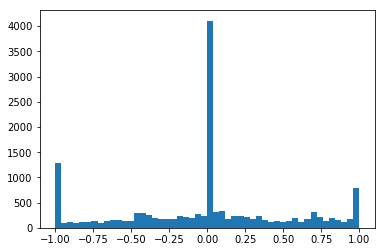

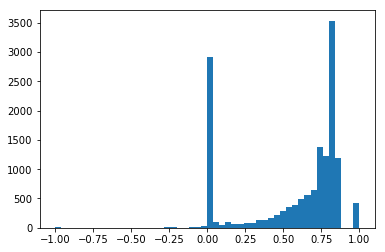

In [73]:
angles = []
throts = []
for i in range(len(frames_h60)):
    rec = tub.get_record(i)
    angle = rec[ANGLE]
    angles.append(angle)
    throt = rec[THROT]
    throts.append(throt)

plt.figure()
plt.hist(angles,bins=50)
plt.figure()
plt.hist(throts,bins=50)

In [74]:
zeros_ct = 0
for a, t in zip(angles, throts):
    if np.abs(a)<0.01 and np.abs(t)<0.01:
        zeros_ct += 1
        
print("Number of simultaneous angle, throttle zeros: " , zeros_ct)

Number of simultaneous angle, throttle zeros:  492


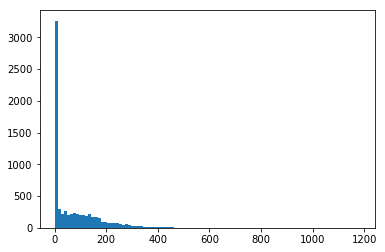

In [75]:
plt.hist(deltas,bins=100);

In [76]:
def make_clean_tub(tub_name, frames_for_diff, frames_to_copy, tub_origin):
    tub_full_path = pj(g_tubs_dir, tub_name)
    if os.path.exists(tub_full_path):
        shutil.rmtree(tub_full_path)
        time.sleep(1)

    os.makedirs(tub_full_path)
    shutil.copyfile( pj(g_tubs_dir, "meta.json"), pj(tub_full_path, "meta.json"))
    shutil.copyfile( pj(tub_origin.path, "0_cam-image_array_.jpg"), pj(tub_full_path, "0_cam-image_array_.jpg"))
    shutil.copyfile( pj(tub_origin.path, "record_0.json"), pj(tub_full_path, "record_0.json"))

    tub_clean = dk.Tub(tub_full_path)
    
    frames_clean = []
    deltas,_ = differentiate_frames(frames_for_diff)
    for i,d in enumerate(deltas):
        if d > 5:
            rec = tub_origin.get_record(i+1)
            rec[X_key] = cv2.cvtColor(frames_to_copy[i+1], cv2.COLOR_BGR2RGB)
            tub_clean.put_record(rec)
            frames_clean.append( frames_to_copy[i+1] )
        
    return frames_clean

In [77]:
frames_clean = make_clean_tub("tub_clean", frames_h60, frames_2h, tub)

Tub does exist


In [78]:
write_frames(frames_clean, pj(g_videos_dir, "tub_clean_video.avi"))

In [80]:
_,dframes = differentiate_frames(frames_2h)
tub_diffs = dk.Tub( pj(g_tubs_dir, "tub_diffs") )
for i, f in enumerate(frames_2h[1:]):
    rec = tub.get_record(i)
    rec[X_key] = cv2.cvtColor(dframes[i-1], cv2.COLOR_BGR2RGB)
    tub_diffs.put_record(rec)
    

Tub does exist
